In [1]:
!pip install numpy scipy patsy pandas

In [2]:
!pip install statsmodels --upgrade

In [3]:
import os
import sys
import pandas as pd
# import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: DelftStack
  # This is added back by InteractiveShellApp.init_path()


In [4]:
#import statsmodels.api as sm
from statsmodels.tsa import ar_model, arima_process, arima, arima_model
from statsmodels.tsa.ar_model import AutoReg

# Simulate an AR(2) process
alphas = np.array([.93, .0333])
betas = np.array([0.])
# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
n_samples = 2048
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ar2 = arima_process.arma_generate_sample(ar=ar, ma=ma, nsample=n_samples) 

Data preparation

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
  #find the end of this pattern
    end_ix = i + n_steps
  # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
  # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [6]:
# split into train and test sets
dataset = ar2
n_steps = 3
step_back = n_steps

train_size = int(len(dataset) * 0.67) 
train_dataset, test_dataset = dataset[0:train_size], dataset[train_size:len(dataset)]

X_train, Y_train = [], []
for i in range(len(train_dataset)-step_back - 1):
    a = train_dataset[i:(i+step_back)]
    X_train.append(a)
    Y_train.append(train_dataset[i + step_back])
X_train = np.array(X_train); Y_train = np.array(Y_train);

X_test, Y_test = [], []
for i in range(len(test_dataset)-step_back - 1):
    a = test_dataset[i:(i+step_back)]
    X_test.append(a)
    Y_test.append(test_dataset[i + step_back])
X_test = np.array(X_test); Y_test = np.array(Y_test);


MLP model having tree dense layers $h_1(n_1),\, h_2(n_2),\, h_3(1)$

In [21]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Dropout

# -------------------------------------
# setup a MLP network in keras
# -------------------------------------

from tensorflow.keras.optimizers import RMSprop,Adam

Nodos1 = 128
Nodos2 = 64
Nodos3 = 1

model = Sequential()
model.add(Dense(Nodos1 , activation='relu', input_dim=n_steps)) #  Nodos1  neurons
# Dropout: A Simple Way to Prevent Neural Networks from Overfitting 
model.add(Dropout(0.2)) 
model.add(Dense(Nodos2, activation='relu', input_dim=n_steps))  
model.add(Dropout(0.2)) 
model.add(Dense(Nodos3, activation='linear', input_dim=n_steps))  
model.compile(optimizer='adam', loss='mse') # Loss Function
#model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate = 0.01))

In [22]:
# fit model
X_in, y = split_sequence(X_train, n_steps)
history = model.fit(X_train, Y_train, epochs=300, batch_size=2,verbose= 0)

# learning curve
hpd = pd.DataFrame(history.history)
hpd[['loss']].plot(figsize=(18, 9))
plt.semilogy()
plt.show()

In [24]:
print()
trainScore = model.evaluate(X_train, Y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))


Train Score: 0.93 MSE (0.96 RMSE)


In [25]:
testScore = model.evaluate(X_test, Y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Test Score: 1.13 MSE (1.06 RMSE)


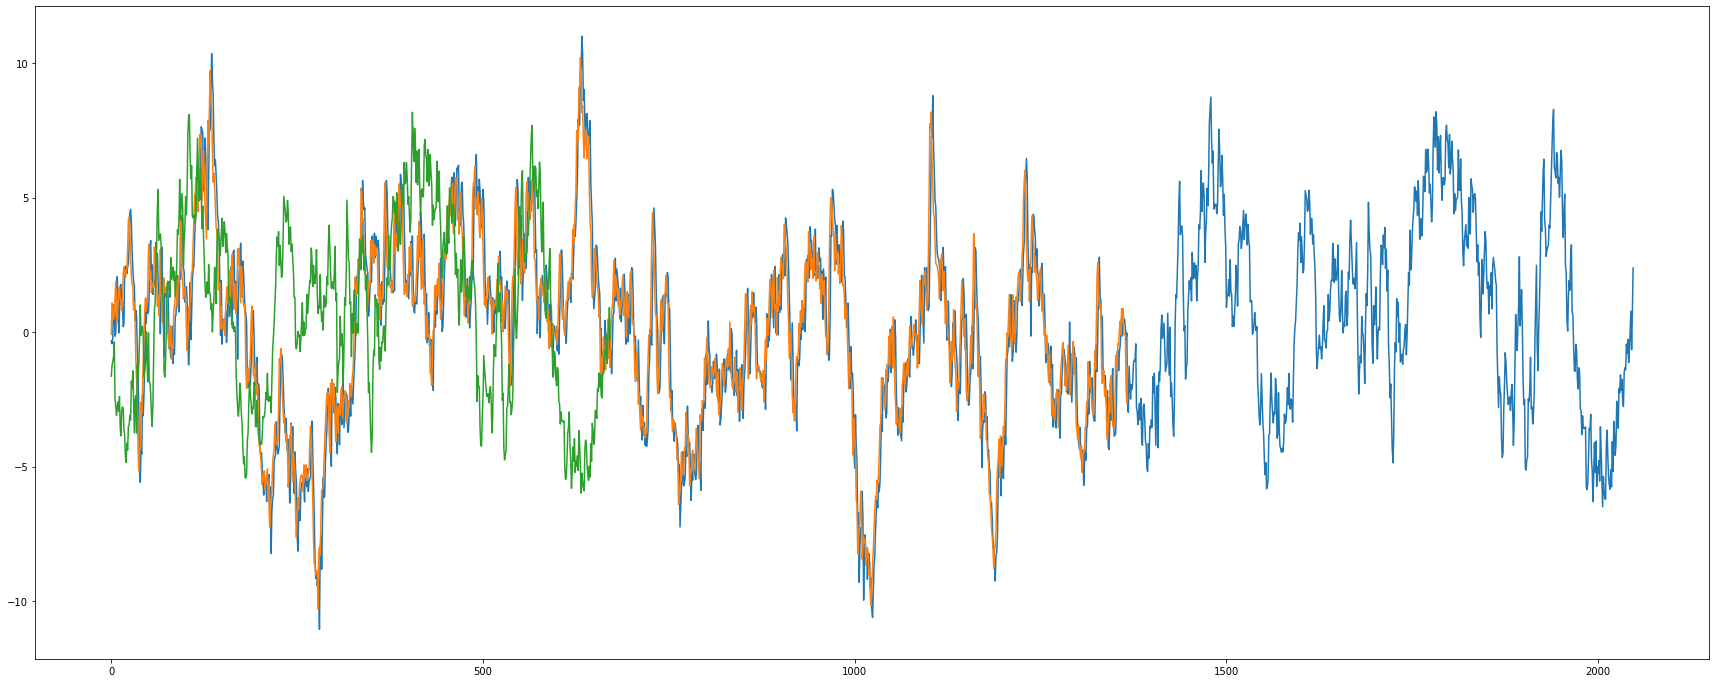

In [26]:
# Evaluate the skill of the Trained model
trainPredict = np.array(model.predict(X_train))
trainPredict = np.reshape(trainPredict, (len(trainPredict), 1))
testPredict = np.array(model.predict(X_test))
testPredict = np.reshape(testPredict, (len(testPredict), 1))    

# plot baseline and predictions
plt.figure(figsize=(30,12))
plt.plot(dataset)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.show()

In [27]:
# Estimate model performance
noise = np.random.normal(0, 0.1, size=n_samples)
X_predict = dataset + noise
X_predict, y_true = split_sequence(X_predict, n_steps)
y_hat = model.predict(X_predict)

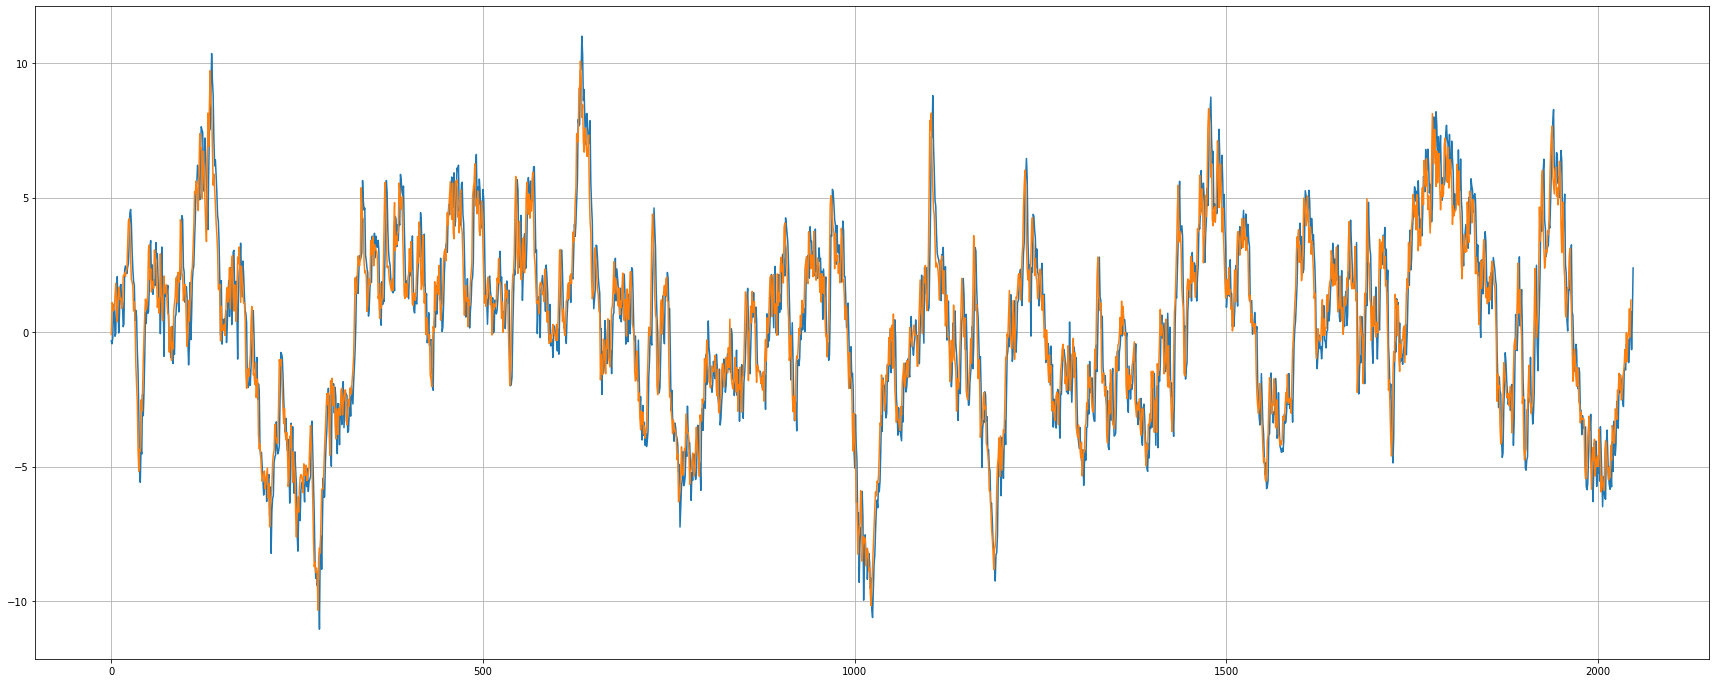

In [28]:
plt.figure(figsize=(30,12))
plt.plot(dataset)
plt.plot(y_hat)
plt.grid()

(array([  2.,   1.,   2.,   7.,   8.,  10.,   9.,   3.,  11.,  14.,  34.,
         36.,  35.,  48.,  53.,  63.,  68.,  76.,  90.,  83.,  87.,  97.,
         44.,  35., 206., 150., 138., 138., 103.,  86.,  64.,  62.,  56.,
         50.,  25.,  16.,  18.,   6.,   5.,   3.,   1.,   2.]),
 array([-6.8385854 , -6.54824   , -6.257895  , -5.96755   , -5.6772046 ,
        -5.3868594 , -5.096514  , -4.806169  , -4.515824  , -4.2254786 ,
        -3.9351335 , -3.6447885 , -3.3544433 , -3.0640981 , -2.773753  ,
        -2.4834077 , -2.1930625 , -1.9027174 , -1.6123722 , -1.322027  ,
        -1.0316818 , -0.7413366 , -0.4509914 , -0.16064623,  0.12969896,
         0.42004412,  0.7103893 ,  1.0007344 ,  1.2910796 ,  1.5814248 ,
         1.87177   ,  2.1621153 ,  2.4524603 ,  2.7428055 ,  3.0331507 ,
         3.3234959 ,  3.613841  ,  3.9041862 ,  4.1945314 ,  4.4848766 ,
         4.775222  ,  5.065567  ,  5.355912  ], dtype=float32),
 <a list of 42 Patch objects>)

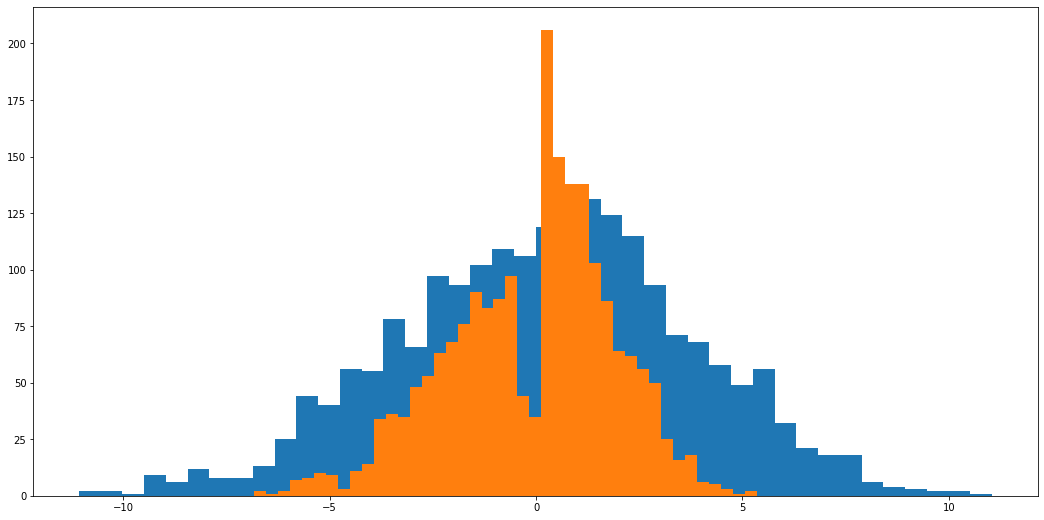

In [17]:
plt.figure(figsize=(18,9))
plt.hist(y_true,bins=42)
plt.hist(y_hat,bins=42)